---
Trabalho Prático 01 da Disciplina DCC207 - Algoritmos 2
# Geometria Computacional e Classificação Linear
---
Alunos:
- Juan Braga
- Lucas Almeida
- Luiz Romanhol

# 1. Introdução

O objetivo deste trabalho é empregar algoritmos de `geometria computacional` para a criação de um modelo de `classificação linear`.

**Descrição:** A partir de um conjunto de dados de treinamento, o algoritmo deve encontrar uma envoltória (contorno) que delimite uma região de classificação para um conjunto de dados (pontos no plano cartesiano). A partir de duas dessas envoltórias, será possível determinar se há separabilidade (ou se elas tem áreas sobrepostas) e então determinar uma reta que separe os dois conjuntos de dados.

**Apresentação do modelo:** Cada etapa do algoritmo será apresentada e explicada separadamente, e utilizará um conjunto de dados aleatório gerado a cada execução. O leitor pode livremente re-executar as células das seções 1 a 5 para visualizar conjuntos de dados diferentes.

Passos envolvidos no modelo (enumerado segundo as seções deste documento/arquivo):
2. Envoltória Convexa (encontrar o contorno)

3. Varredura Linear (definir separabilidade/sobreposição entre modelos)

4. Modelo de Classificação (encontrar a reta de separabilidade)

5. Classificador e cálculo de métricas (computar teste e calcular precisão do modelo gerado)

Uma vez apresentado o algoritmo e sua interface definida, serão realizados testes e calculadas métricas de precisão para o modelo em diferentes bases de dados.

Importação de bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Primitivas
Para a execução dos algoritmos de geometria computacional, serão utilizadas algumas primitivas apresentadas em aula:

> A função `orientacao()` determina a orientação relativa entre três pontos no plano cartesiano. A partir da determinação do sinal do determinante da matriz formada pelos três pontos, é possível determinar se os pontos estão em sentido horário, anti-horário ou colineares. Com esta informação, se soubermos que dois pontos pertencem a uma reta, podemos determinar para qual lado o terceiro ponto está.

Tal escolha almeja evitar operações de divisão entre os pontos, que podem produzir imprecisões indesejadas que podem se propagar ao longo do algoritmo (o fenômeno chamado de *underflow*).

Seguindo o Teorema 22.1 do livro Algorithm Design and Applications (por Goodrich e Tamassia), de 2015.

In [ ]:
from codigoModularizado.primitivas import orientacao

> Aqui, o uso da distância quadrada na função `distanciaQuadrada` também se dá para evitar o uso de divisão em operações mais tradicionais, como a Distância Euclidiana.

In [ ]:
from codigoModularizado.primitivas import distanciaQuadrada

> Uma função para determinar se um dado ponto está sobre um segmento de linha (um par de pontos).

In [ ]:
from codigoModularizado.primitivas import estaNoSegmento

A função `segmentosInterceptam` determina se dois segmentos se interceptam.

Como cada segmento é representado como um par de pontos no plano cartesiano, a função `orientacao` é utilizada para determinar se cada ponto de um segmento está de um lado diferente do outro segmento.

In [ ]:
from codigoModularizado.primitivas import segmentosInterceptam

## 1.2 Funções auxiliares

Para a implementação do algoritmo, serão aqui inicializadas bibliotecas e definidas funções para gerar conjuntos de dados aleatórios e também "plotá-los".

**Geração de pontos:**

> Função `geraRect` produz uma nuvem de pontos aleatórios dentro de um retângulo (bom para produzir casos com pontos colineares ao âncora)

> Função `geraCirc` produz uma nuvem de pontos aleatórios dentro de um círculo.

> Função `geraPontos` escolhe aleatóriamente entre `geraRect` e `geraCirc` para gerar os pontos.

> Função `plotaPontos` usa a biblioteca matplotlib para visualizar um conjunto de pontos.

In [ ]:
from codigoModularizado.auxiliaresGeometria import geraRect
from codigoModularizado.auxiliaresGeometria import geraCirc
from codigoModularizado.auxiliaresGeometria import geraPontos
from codigoModularizado.auxiliaresGeometria import plotaPontos
from codigoModularizado.auxiliaresGeometria import desenha_pontos

**Plotar o desenho da envoltória**

In [ ]:
from codigoModularizado.envoltoria import desenhaEnvoltoria

# 2. Envoltória Convexa

O primeiro passo para a criação do modelo é encontrar o contorno de um dado conjunto de dados (pontos no plano). Para isso, foi escolhido o algoritmo da `Envoltória Convexa de Graham`.

> **Descrição do algoritmo:**
1. Encontrar o ponto com menor coordenada y (se houver empate, escolher o de menor coordenada x). Este ponto é chamado de âncora.
2. Ordenar os pontos restantes em ordem crescente de acordo com o ângulo que eles formam com o âncora e a horizontal.
3. Iniciar uma pilha vazia.
4. Empilhar o âncora e o primeiro ponto da ordenação.
5. Para cada ponto restante, enquanto a orientação formada pelos três pontos do topo da pilha for anti-horária, desempilhar o topo da pilha.
6. Empilhar o ponto restante.

Note que a principal parte do algoritmo se trata do critério com o qual os pontos são ordenados no passo 2. As primitivas `orientacao` e `distanciaQuadrada` são essenciais, pois permitem definir o "ângulo polar" relativo entre cada um dos pontos em relação ao ponto âncora, sem usar operações de divisão (como a `atan2` da biblioteca `math`).

In [ ]:
from codigoModularizado.envoltoria import envoltoriaConvexa

**Visualizando a envoltória encontrada**

Utilizando as funções auxiliares da Seção 1, vamos criar uma nuvem de pontos aleatória e checar como a envoltória ficará no plano cartesiano.

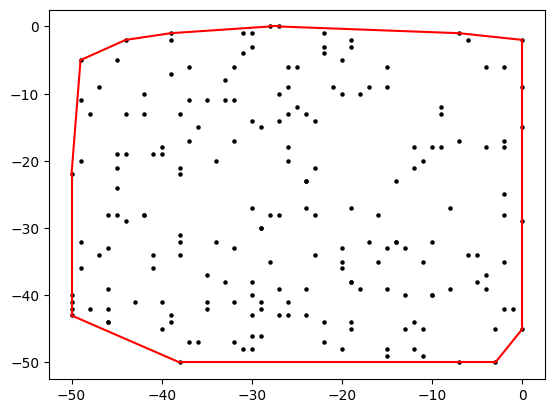

In [ ]:
p = geraPontos(200, (-50,0))
env = envoltoriaConvexa(p)

desenhaEnvoltoria(env, p, show=True)

# 3. Varredura Linear

O segundo passo para a criação do modelo, uma vez que já temos duas envoltórias convexas, é determinar se elas são separáveis ou não (isto é, se há sobreposição entre as áreas das envoltórias). Para isso foi escolhido o algoritmo da `Varredura Linear`.

Ele consiste em descobrir se os lados dos polígonos (envoltórias) se cruzam. Isto é feito ao percorrer os pontos da esquerda para a direita, verificando se as retas próximas se encontram com a reta que contém o ponto atual (utilizando a primitiva `orientacao`, veja a seção 1.1 para maiores detalhes).

O principal componente do algritmo da varredura é sua ordenação, pois é ela que irá ditar sua complexidade assintótica de tempo. Assim, definimos primeiro a implementação de uma `árvore binária balanceada` para garantir uma complexidade $O(n*\log(n))$, que irá ordenar os pontos de acordo com a coordenada y de cada *endpont* (pontos que compõem cada uma das retas).

Antes de realizar a varredura, é necessário perparar os dados. Note que as envoltórias são retornadas do `Algoritmo de Graham` na forma de lista de pontos, enquanto a função `varreduraLinear` espera uma lista de segmentos (pares de pontos). Portanto, é necessário converter as listas de pontos das duas envoltórias em uma única lista de segmentos.

A função `preparaSegmentos` recebe as duas listas de pontos das envoltórias e retorna a lista de segmentos pronta para a varredura linear.

In [ ]:
from codigoModularizado.varreduraLinear import preparaSegmentos

>**Descrição do algoritmo:**
1. Criar a lista de pontos com as extremidades dos segmentos.
2. Ordenar a lista pelas coordenadas `x` dos pontos e, em caso dê empate, colocar uma extremidade esquerda de um segmento antes da extremidade direita de outro.
3. Criar árvore binária com o primeiro ponto da lista.
4. Para cada segmento da lista:
	1. Se for uma extremidade esquerda, insere na árvore e verifica interseção do segmento com os segmentos logo acima e logo abaixo.
	2. Se for uma extremidade direita, verifica interseção entre os segmentos logo acima e logo abaixo do segmento e remove o segmento
5. Se em alguma verificação houver segmento, retorna `True`. Se percorrer todo o vetor e não houverem interseções, retorna `False`.

In [ ]:
from codigoModularizado.varreduraLinear import varreduraLinear

**Visualizando as envoltórias e definindo a sobreposição.**

Utilizando as funções auxiliares da Seção 1, vamos criar duas nuvens de pontos e verificar se há sobreposição entre seus contornos (envoltórias).

Execute quantas vezes precisar, há chances dos conjuntos se sobreporem ou não a cada execução.

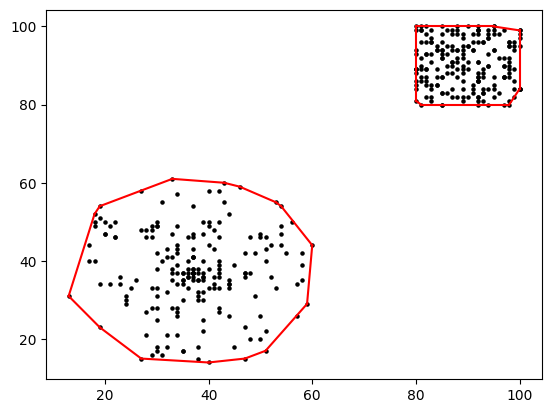

As envoltórias convexas não se intersectam.


In [ ]:
p1 = geraPontos(200, (80,100))
env1 = envoltoriaConvexa(p1)
desenhaEnvoltoria(env1, p1)

p2 = geraPontos(200, (25,75))
env2 = envoltoriaConvexa(p2)
desenhaEnvoltoria(env2, p2)

plt.show()

segmentosVarredura = preparaSegmentos(env1, env2)

intersecao = varreduraLinear(segmentosVarredura)

if intersecao:
    print("As envoltórias convexas se intersectam.")
else:
    print("As envoltórias convexas não se intersectam.")

# 4. Modelo de Classificação

Com as duas envoltórias em mãos e o conhecimento de elas não têm sobreposição, podemos definir o `modelo de classificação linear`.

Isto será feito ao encontrarmos uma linha (ou melhor, a equação de uma linha) que separe ambos os conjuntos.

>**Descrição do algoritmo:**
> 1. Encontrando os pontos mais próximos de cada envoltória
> 2. Encontrar o ponto médio na reta que liga estes dois pontos, onde a reta passará.
> 3. Encontrar a reta de separação dos conjuntos, que deverá ser tangente à reta que liga os pontos mais próximos e passar através do ponto médio.

Primeiro precisamos **encontrar os pontos mais próximos de cada envoltória**, ou seja, o par de pontos que têm a menor distância e que sejam de contornos diferentes.

`Uma abordagem quadrática foi tomada`, comparando todos os pares possíveis de pontos. Apesar de outras técnicas terem sido consideradas, como bibliotecas de python que usariam o algoritmo mais eficiente de Gilbert-Johnson-Keerthi (que usaria simplex), ou uma possível alteração do algoritmo da seção 22.4 do livro Algorithm Design and Applications (por Goodrich e Tamassia, de 2015), os alunos julgaram que seria o mais rápido de se implementar.

In [ ]:
from codigoModularizado.modelo import pontos_mais_proximos

Em seguida **calculamos o ponto médio entre esses pontos**. Neste caso a divisão é inevitável.

In [ ]:
from codigoModularizado.modelo import calcula_ponto_medio

Por fim, usamos a informação dos pontos mais próximos e do ponto médio para **encontrar a reta que é tangente à reta entre os pontos**, e que passe pelo ponto médio delas.

**Lembremos da equação de uma reta:** $(a*x + b)$, onde $a$ é a inclinação e $b$ é o coeficiente linear.

In [ ]:
from codigoModularizado.modelo import linha_classificadora

**Visualizando os resultados.**
Aqui vamos encontrar os pontos mais próximos, o ponto médio e a equação da reta tangente que desejamos.

Note que as envoltórias são aleatórias, e podem não ser separáveis. Por favor continue re-executando até que um resultado separável ocorra.

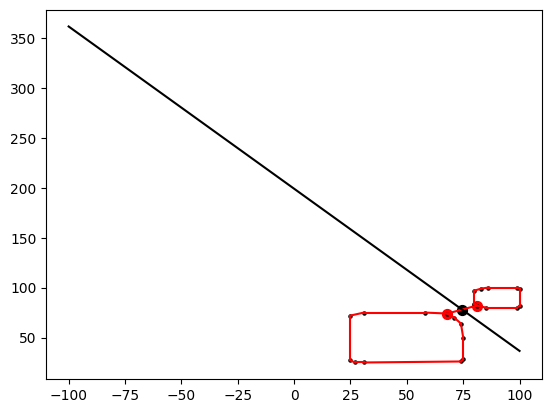

In [ ]:
# Gera dois conjuntos de dados e verifica a separabilidade
env1 = envoltoriaConvexa(geraPontos(200, (80,100)))
env2 = envoltoriaConvexa(geraPontos(200, (25,75)))
intersecta = varreduraLinear(preparaSegmentos(env1,env2))

pontos = pontos_mais_proximos(env1, env2)
ponto_medio = calcula_ponto_medio(pontos[0], pontos[1])
linha = linha_classificadora(env1, env2)

# Plot dos pontos mais próximos e do ponto médio
plt.scatter(*zip(*pontos), s=50, c='red')
plt.scatter(*ponto_medio, s=50, c='black')
plt.plot([pontos[0][0], pontos[1][0]], [pontos[0][1], pontos[1][1]], c='red')

# Plot da reta tangente passando pelo ponto médio
plt.plot([-100, 100], [linha[0] * -100 + linha[1], linha[0] * 100 + linha[1]], c='black')

# Restante do código para plotar as envoltórias
desenhaEnvoltoria(env1)
desenhaEnvoltoria(env2)

plt.show()
if not intersecta:
  print("As envoltórias convexas se intersectam.")

# 5. Classificador e Produtor de Métricas

Com as ferramentas apresentadas em mãos, a `envoltória` a `varredura` e o `modelo classificador`, iremos agora criar uma interface para aplicar estes algoritmos a qualquer conjunto de dados.

A interface escolhida será na forma de uma clase `Classificador`, que será criada a partir de duas bases de dados e irá automaticamente:
- Dividir os dados em conjuntos treinamento/teste
- Produzir o modelo de classificação linear
- Calcular as métricas de precisão para o conjunto de teste

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

from codigoModularizado.classificador import Classificador

**Visualizando os resultados.**

Note que as envoltórias são aleatórias, e podem não ser separáveis. Por favor continue re-executando até que um resultado separável ocorra.

In [ ]:
# Gera dois conjuntos de dados e verifica a separabilidade
pontos1 = np.array(geraPontos(200, (80,100)))
pontos2 = np.array(geraPontos(200, (25,75)))
env1 = envoltoriaConvexa(pontos1)
env2 = envoltoriaConvexa(pontos2)

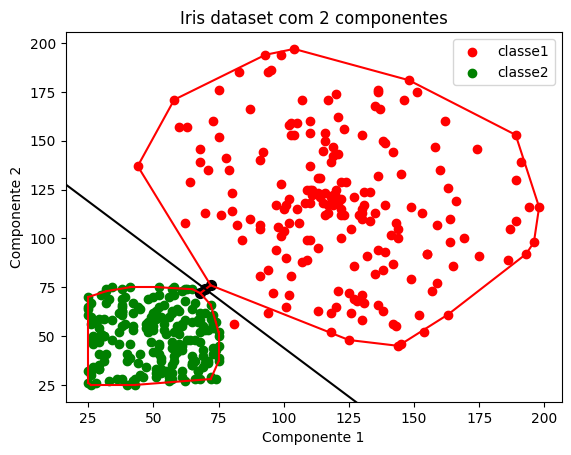

In [ ]:
Classificador(pontos1,pontos2,"classe1","classe2")

# 6. Definição dos datasets

## Iris Dataset

O conjunto de dados `Iris` contém informações sobre três espécies de flores Iris, sendo elas: Setosa, Versicolor e Virginica. Para cada espécie, quatro características botânicas são registradas: o comprimento e largura das sépalas e o comprimento e largura das pétalas.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()

pd.DataFrame(iris.data).head(2)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
iris_2d = svd.fit_transform(iris.data)

setosa_points = iris_2d[iris.target == 0]
versicolor_points = iris_2d[iris.target == 1]
virginica_points = iris_2d[iris.target == 2]

## Wine dataset
O conjunto de dados `Wine` contém informações sobre três tipos de vinhos. Para cada vinho, temos dadods como teor alcoólico, acidez, intensidade da cor, entre outros. No total são 13 atributos, todos numéricos.

In [ ]:
from sklearn.datasets import load_wine
wine = load_wine()

pd.DataFrame(wine.data).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


In [ ]:
svd = TruncatedSVD(n_components=2)
wine_2d = svd.fit_transform(wine.data)

wine_classe0 = wine_2d[wine.target == 0]
wine_classe1 = wine_2d[wine.target == 1]
wine_classe2 = wine_2d[wine.target == 2]

## Page Blocks dataset
De https://archive.ics.uci.edu/ml/datasets/Page+Blocks+Classification.

In [ ]:
url = 'https://github.com/juanmbraga/linear-classifier-with-computational-geometry/raw/main/databases/page-blocks-database.csv'
p_blocks = pd.read_csv(url)
p_blocks.head()

svd = TruncatedSVD(n_components=2)
p_blocks_2d = svd.fit_transform(p_blocks[p_blocks.columns[:-1]])

# Avaliação das Métricas

Por fim, vamos calcular diversas métricas e analisar o resultado.

## Teste 1 - Classes Setosa e Versicolor

Os dados das classes Setosa e Versicolor são bem separados, não se sobrepõem.
O modelo obteve uma taxa de acerto de 100% tanto no treinamento quanto no teste.
A precisão e revocação também são ideais, com valores de 1.0.

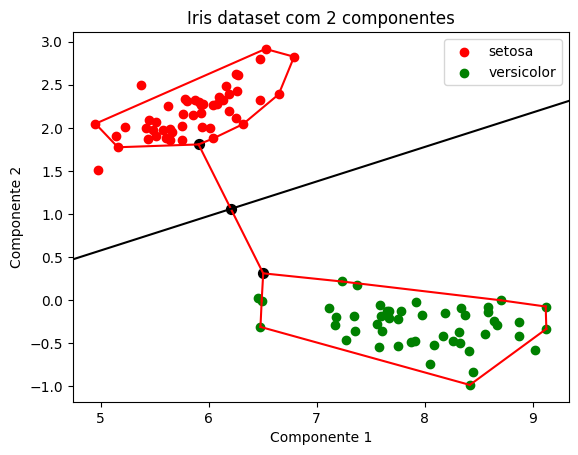

Para a classificação entre setosa e versicolor temos que:
Se interceptam: False
Porcentagem de acertos (treino): 100.0
Porcentagem de erros (treino): 0.0
Porcentagem de acertos (teste): 100.0
Porcentagem de erros (teste): 0.0
Índice de acerto: 100.0 %
Precisão: 1.0
Revocação: 1.0



In [ ]:
teste1 = Classificador(setosa_points,versicolor_points,"setosa","versicolor")
teste1.exibir_metricas()

## Teste 2 - Classes Virginica e Versicolor
As classes Virginica e Versicolor têm uma sobreposição considerável, e não são linearmente separáveis. Por causa disso, o modelo não foi calculado e as métricas não foram feitas.

In [ ]:
teste2 = Classificador(virginica_points,versicolor_points,"virginica","versicolor")
teste2.exibir_metricas()

Os dados de treinamento de virginica e versicolor não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes virginica e versicolor não são separáveis



## Teste 3 - Classes Setosa e Virginica
Assim como a Setosa e a Versicolor, as classes Setosa e Virginica são bem separadas.
O modelo obteve uma taxa de acerto de 100% tanto no treinamento quanto no teste.
A precisão e revocação também são ideais, com valores de 1.0.

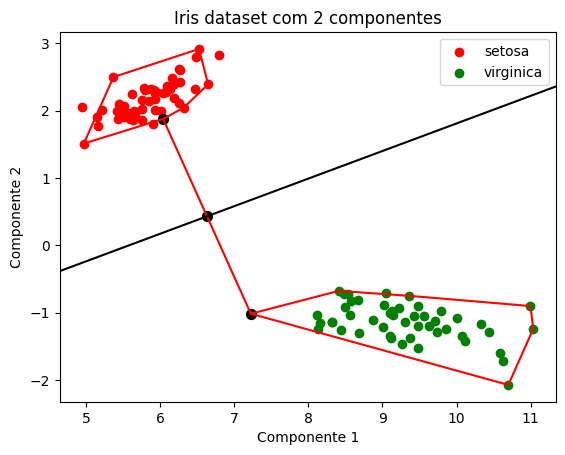

Para a classificação entre setosa e virginica temos que:
Se interceptam: False
Porcentagem de acertos (treino): 100.0
Porcentagem de erros (treino): 0.0
Porcentagem de acertos (teste): 100.0
Porcentagem de erros (teste): 0.0
Índice de acerto: 100.0 %
Precisão: 1.0
Revocação: 1.0



In [ ]:
teste3 = Classificador(setosa_points,virginica_points,"setosa","virginica")
teste3.exibir_metricas()

Os resultados destes três primeiros testes indicam que o modelo foi altamente eficaz no dataset iris, separando corretamente os dados quando separáveis e indentificando quando não são.

Os próximos 3 testes foram feitos com a base de dados wine, e mostram diferentes casos de interseção de envoltórias

## Teste 4 - Classes 0 e 1

In [ ]:
teste4 = Classificador(wine_classe0, wine_classe1, "wine_0", "wine_1")
teste4.exibir_metricas()

Os dados de treinamento de wine_0 e wine_1 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_0 e wine_1 não são separáveis



## Teste 5 - Classes 0 e 2

In [ ]:
teste5 = Classificador(wine_classe0, wine_classe2, "wine_0", "wine_2")
teste5.exibir_metricas()

Os dados de treinamento de wine_0 e wine_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_0 e wine_2 não são separáveis



## Teste 6 - Classes 1 e 2

In [ ]:
teste6 = Classificador(wine_classe1, wine_classe2, "wine_1", "wine_2")
teste6.exibir_metricas()

Os dados de treinamento de wine_1 e wine_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_1 e wine_2 não são separáveis



## Teste 7 - Dataset wine com alterações - Classes 0 e 1

In [ ]:
wine = load_wine()

wine_data = wine.data

wine_data = wine_data[:, [2,4,5,6,10]]

svd = TruncatedSVD(n_components=2)
wine_teste = svd.fit_transform(wine_data)

wine_teste_0 = wine_teste[wine.target == 0]
wine_teste_1 = wine_teste[wine.target == 1]
wine_teste_2 = wine_teste[wine.target == 2]

In [ ]:
teste7 = Classificador(wine_teste_0, wine_teste_1, "wine_teste_0", "wine_teste_2")
teste7.exibir_metricas()

Os dados de treinamento de wine_teste_0 e wine_teste_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_teste_0 e wine_teste_2 não são separáveis



## Teste 8 - Dataset wine com alterações - Classes 0 e 2

In [ ]:
teste8 = Classificador(wine_teste_0, wine_teste_1, "wine_teste_0", "wine_teste_1")
teste8.exibir_metricas()

Os dados de treinamento de wine_teste_0 e wine_teste_1 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_teste_0 e wine_teste_1 não são separáveis



## Teste 9 - Dataset wine com alterações - Classes 1 e 2

In [ ]:
teste9 = Classificador(wine_teste_1, wine_teste_2, "wine_teste_1", "wine_teste_2")
teste9.exibir_metricas()

Os dados de treinamento de wine_teste_1 e wine_teste_2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes wine_teste_1 e wine_teste_2 não são separáveis



## Teste 10 - Mescla do wine original e com alterações

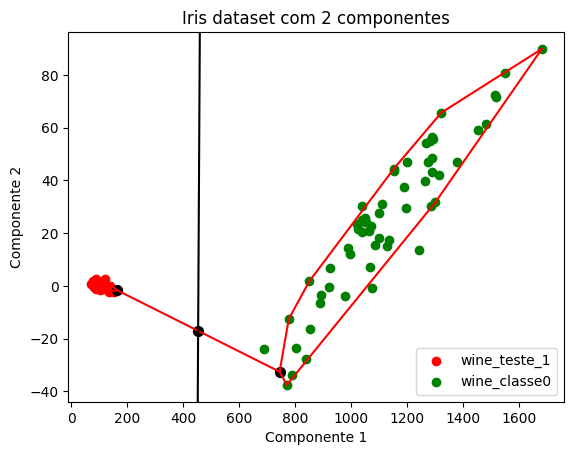

Para a classificação entre wine_teste_1 e wine_classe0 temos que:
Se interceptam: False
Porcentagem de acertos (treino): 0.0
Porcentagem de erros (treino): 100.0
Porcentagem de acertos (teste): 0.0
Porcentagem de erros (teste): 100.0
Índice de acerto: 0.0 %
Precisão: 0.0
Revocação: 0.0



In [ ]:
teste10 = Classificador(wine_teste_1, wine_classe0, "wine_teste_1", "wine_classe0")
teste10.exibir_metricas()

## Teste 11 - Page-blocks

In [ ]:
# Executa o classificador nas classes
teste11 = Classificador(p_blocks_2d[p_blocks["Class"]==1], p_blocks_2d[p_blocks["Class"]==2], "classe1", "classe2")
teste11.exibir_metricas()

Os dados de treinamento de classe1 e classe2 não são separáveis
Não há como realizar métricas pois os dados de treinamento das classes classe1 e classe2 não são separáveis

